In [1]:
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

from sketch_util import create_img
from sketch_io   import get_ith_name, class_names
features_directory    =  '../features'
cl_names = class_names()

Populating the interactive namespace from numpy and matplotlib


# Read from stored numpy files

In [2]:
!ls ../features/

ev_keys.npy	     ev_logits_vrnn.npy  tr_logits_blstm.npy
ev_labels.npy	     ev_sketches.npy	 tr_logits_cnn.npy
ev_lengths.npy	     tr_keys.npy	 tr_logits_vrnn.npy
ev_logits_blstm.npy  tr_labels.npy	 tr_sketches.npy
ev_logits_cnn.npy    tr_lengths.npy


In [3]:
features_dir = '../features'
names = ['keys', 'lengths', 'sketches', 'labels', 'logits_vrnn', 'logits_blstm', 'logits_cnn']

# tr = {name:np.load('{}/{}_{}.npy'.format(features_dir, 'tr', name)) for name in names}
# ev = {name:np.load('{}/{}_{}.npy'.format(features_dir, 'ev', name)) for name in names}

def get_data(name, mode='tr'):
    assert name in names
    assert mode in ['tr', 'ev']
    
    return np.load('{}/{}_{}.npy'.format(features_dir, mode, name))

In [4]:
tr = {name: get_data(name, mode='tr') for name in names}
ev = {name: get_data(name, mode='ev') for name in names}

tr.keys(), ev.keys()

(dict_keys(['labels', 'logits_blstm', 'logits_vrnn', 'logits_cnn', 'lengths', 'keys', 'sketches']),
 dict_keys(['labels', 'logits_blstm', 'logits_vrnn', 'logits_cnn', 'lengths', 'keys', 'sketches']))

In [5]:
# Features to load
num_samples = tr['keys'].shape[0]
num_eval    = ev['keys'].shape[0]
num_samples, num_eval

(1000000, 1700000)

# Output candidates sketches of a certain class

80540 80598 81092 81455 81910 82046 82440 82602 

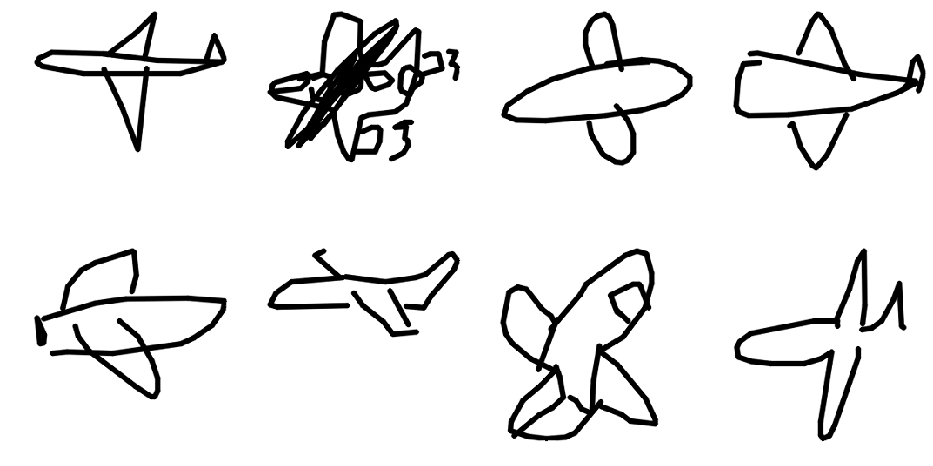

In [6]:
# Output range of images of class x

name   = 'airplane'
start  = 80000
rows   = 2
cols   = 4
num    = rows * cols

size = 4
plt.figure(figsize=(cols*size,(num//cols)*size))

index = start - 1
for i in range(num):
    while True:
        index += 1
        if cl_names[ev['labels'][index]] == name:
            print(index, end=' ')
            break
        
    
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
#     plt.title(cl_names[ev['labels'][index]])
    img = 255 - create_img(ev['lengths'][index], ev['sketches'][index])
    plt.imshow(np.reshape(img, (224,224)), cmap='gray')

# Faulty images (from selected indices)

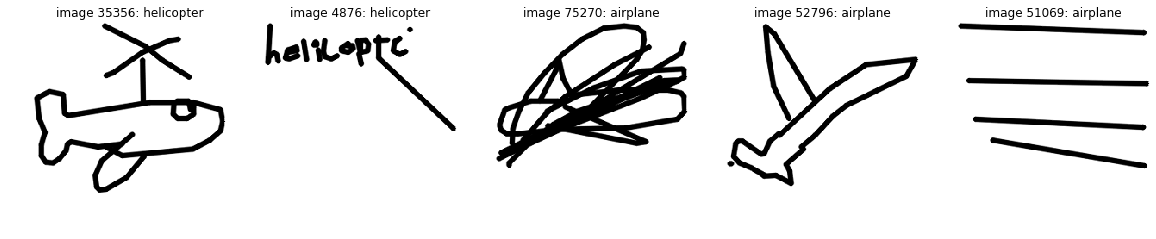

In [7]:
indexes = [35356, 4876, 75270, 52796, 51069]
n = len(indexes)

plt.figure(figsize=(n*4,4))

for i,index in enumerate(indexes):
    plt.subplot(1, n, i+1)
    plt.axis('off')
    plt.title("image {}: ".format(index) + cl_names[ev['labels'][index]])
    img = 255 - create_img(ev['lengths'][index], ev['sketches'][index])
    plt.imshow(np.reshape(img, (224,224)), cmap='gray')

# Nearest Neighbors in Representation space

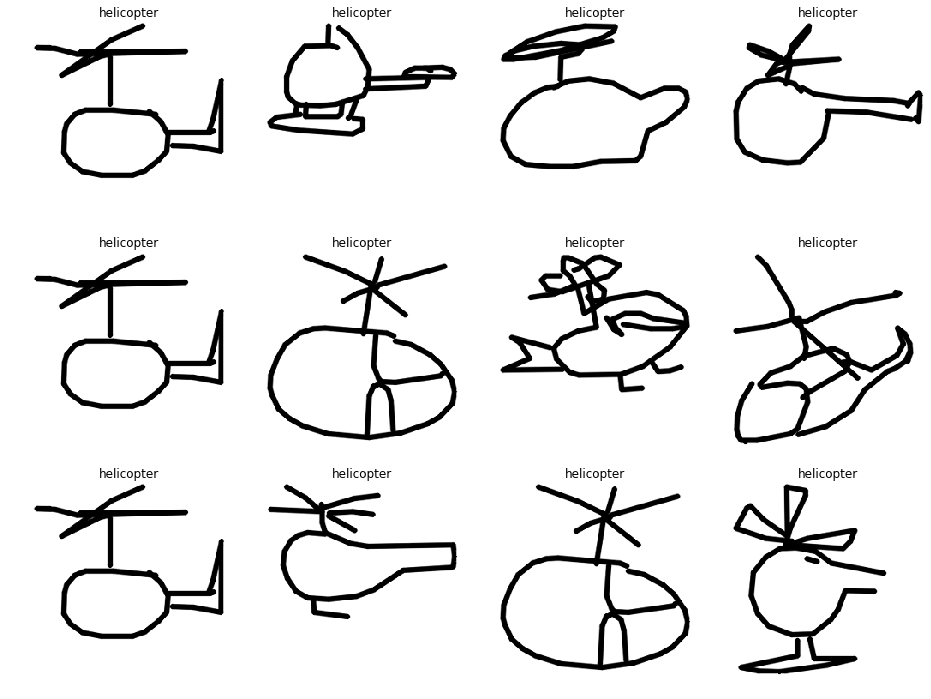

In [9]:
# for i in range(10):
index = 3565
# features = (features_vgg16, features_inception, features_resnet, features_threesplit_resnet)
# eval_features = (eval_features_vgg16, eval_features_inception, eval_features_resnet, eval_features_threesplit_resnet)

features      = (tr['logits_cnn'], tr['logits_blstm'], tr['logits_vrnn'])
eval_features = (ev['logits_cnn'], ev['logits_blstm'], ev['logits_vrnn'])

def closestk(feature, all_features, k=4):
    diffs     = all_features - feature
    sq_diffs  = np.square(diffs)
    msq_diffs = np.mean(sq_diffs, axis=1)
    closestk  = np.argsort(msq_diffs)[:k]
    return closestk

num_rows = len(features)
num_cols = 4
plt.figure(figsize=(num_cols*4, num_rows*4))

for i, (feature, eval_feature) in enumerate(list(zip(features, eval_features))):
    start_id = num_cols*i + 1
    plt.subplot(num_rows, num_cols, start_id)
    plt.axis('off')
    plt.title(cl_names[ev['labels'][index]]) 
    ev_img = 255 - create_img(ev['lengths'][index], ev['sketches'][index])
    plt.imshow(np.reshape(ev_img, (224,224)), cmap='gray') 

    closest = closestk(feature=eval_feature[index], all_features=feature, k=num_cols-1)
    for j,c_id in enumerate(closest): 
        plt.subplot(num_rows, num_cols, start_id+j+1)
        plt.axis('off')
        plt.title(cl_names[ev['labels'][c_id]])        
        cl_img = 255 - create_img(ev['lengths'][c_id], ev['sketches'][c_id])
        plt.imshow(np.reshape(cl_img, (224,224)), cmap='gray')

# KNN Classification

In [ ]:
neighbors = 3
num_take  = 10000
names         = ('resnet', 'blstm', 'vrnn')


def closestk(feature, all_features, k=4):
    diffs     = all_features - feature
    sq_diffs  = np.square(diffs)
    msq_diffs = np.mean(sq_diffs, axis=1)
    closestk  = np.argsort(msq_diffs)[:k]
    return closestk

index_choices = np.random.choice(num_eval, size=num_take, replace=False)
for cur_name, cur_features, cur_eval_features in zip(names, features, eval_features):
    correct_chosen = 0
    for index in index_choices:
        if (i+1)%500 == 0: print("Step", i+1)
        cur_label = ev['labels'][index]

        selections = closestk(cur_eval_features[index], cur_features, neighbors)
        selections = list(map(lambda x: tr['labels'][x], selections))
        otherchoices = set(selections)
        otherchoices.discard(cur_label) # only have different
        if not bool(otherchoices):
            correct_chosen += 1
            continue
        num_this = selections.count(cur_label)
        num_other = [selections.count(choice) for choice in otherchoices]
        if max(num_other) > num_this: 
            pass
        else:
            correct_chosen += 1
            
    print("Accuracy for network {:10} {:.5f}".format(cur_name, correct_chosen/num_eval))